<a href="https://colab.research.google.com/github/DrAlexSanz/nlpv2-course/blob/master/Cypher_decryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to decrypt a substitution cypher assuming the original message was written in english.

The approach is to first get a language model that captures the probability of a letter following another letter (or two).

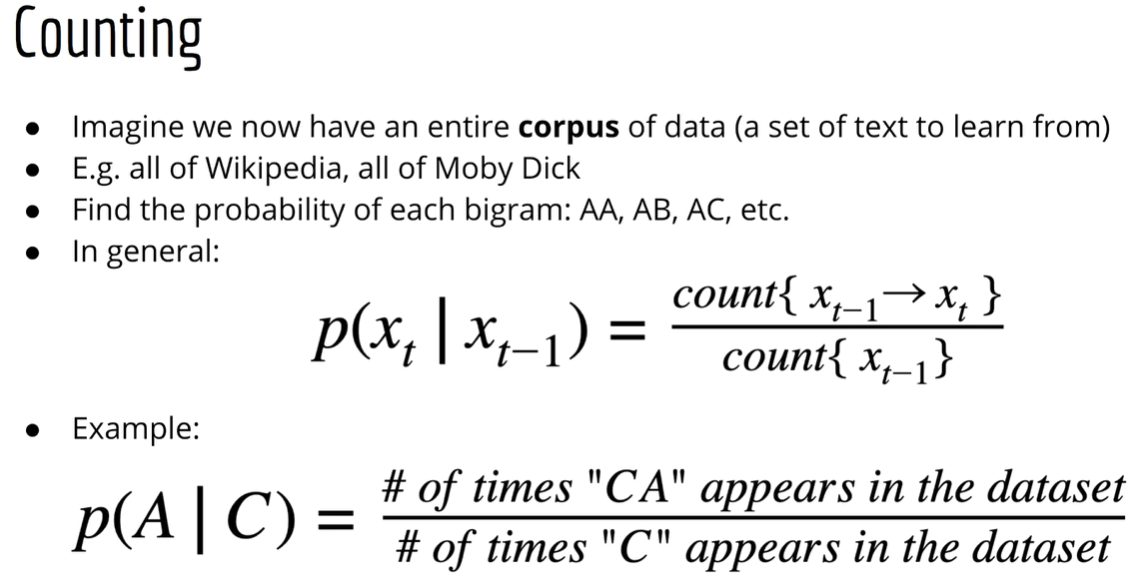

One option is brute force. Generate all the possible decoded messages and check them. If there are 26 letters and they can all go in each position I have 26! possible messages. That is $𝓞(4\cdot 10^{26})$

Using a genetic algorithm I can find a mapping that solves my problem. It's not a differentiable function so no gradient descent here. My output will be a dictionary of the form code = {"A": "L", "B": "X"...}

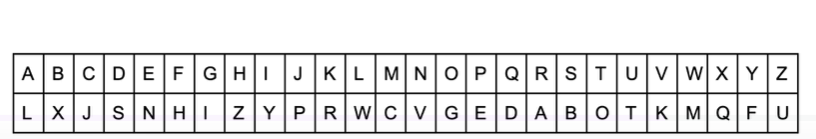

In the genetic algorithm part:
* Mutations can be insertion, deletion or permutation. Since I have a dictionary mapping (I need all letters and they have to be unique), I can only swap letters (keys or values).
* Just start with random dictionary. Swap a few characters and generate a few possibilities. If the new dictionary is fitter than the old one, we keep the new, otherwise we keep the old.
* I don't need to have two parents and one child, that's a hyperparameter. I can have a few random dictionaries and evolve them separately. That reduces the chance of staying in a local optimum.

In [265]:
import numpy as np
import textwrap

import matplotlib.pyplot as plt
import string
import random
import re
import os
import requests

In [266]:
# Create the substitution cypher as per the image above

letters_key = list(string.ascii_lowercase)
letters_value = list(string.ascii_lowercase)

# I still don't know true mapping but the sender and receiver do, so I create it to compare with the guessed mapping later

true_mapping = {}

random.shuffle(letters_value)

for k, v in zip(letters_key, letters_value):
    true_mapping[k] = v

true_mapping

{'a': 'f',
 'b': 'a',
 'c': 's',
 'd': 'z',
 'e': 'p',
 'f': 'r',
 'g': 'l',
 'h': 'q',
 'i': 'v',
 'j': 'd',
 'k': 'e',
 'l': 'g',
 'm': 'i',
 'n': 't',
 'o': 'x',
 'p': 'b',
 'q': 'j',
 'r': 'y',
 's': 'o',
 't': 'm',
 'u': 'u',
 'v': 'n',
 'w': 'h',
 'x': 'w',
 'y': 'k',
 'z': 'c'}

In [267]:
# Now we create the language model

# Initialize Markov Matrix.

M = np.ones((26, 26))

# Initial state distribution. Again, I'll populate it later.
pi = np.zeros(26)

# Function to update the Markov matrix

def update_transition_m(ch1, ch2):
    """ 
    Transition from ch1 to ch2
    In ASCII, 'a' = 97, 'b' = 98... and then the capital leters
    """
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i, j] += 1 # Transition matrix is a count --> probability
    
    return

# Similar function to update the initial state distribution

def update_pi(ch):
    i = ord(ch) - 97
    pi[i] += 1

    return

# Calculate the log probability of a word/token

def get_log_prob(word):
  
    i = ord(word[0]) - 97 # This is the first character of the word
    logp = np.log(pi[i])

    for ch in word[1:]: # For the rest of the characters
        j = ord(ch) - 97
        logp += np.log(M[i, j])
        i = j # i was still the previous letter, let's update it.

    return logp

# Probability of a sequence of words

def get_prob_sequence(sentence):
    # If it's a string, let's split it into a list of strings.
    # If it's already a list, don't need to do anything.
    if type(sentence) == str:
        sentence = sentence.split()

    logp = 0

    for word in sentence:
        logp += get_log_prob(word)

    return logp

In [268]:
# Download the file

if not os.path.exists("moby_dick.txt"):
    print("Downloading Moby dick...")
    r = requests.get("https://lazyprogrammer.me/course_files/moby_dick.txt")
    print("Finished downloading Moby dick...")
    with open("moby_dick.txt", "w") as f:
        f.write(r.content.decode()) # It's overwriting the original one, but it's ok

In [269]:
# Replace non-alphanumeric characters

regex = re.compile("[^a-zA-Z]")

for line in open("moby_dick.txt"):
    line = line.rstrip()

    # There are blank lines in the file
    if line:
        line = regex.sub(" ", line) # Replace non-alpha with a space

        tokens = line.lower().split()
        for token in tokens:
            # Update the model
            # First letter
            ch0 = token[0]
            update_pi(ch0)

            # Rest of letters
            for ch1 in token[1:]:
                update_transition_m(ch0, ch1)
                ch0 = ch1

# Normalize probs. Check that M is 26x26 and pi is 26
pi = pi/pi.sum()
M = M / M.sum(axis = 1, keepdims = True)

In [270]:
M.shape

(26, 26)

In [271]:
# Create the original message. Create 3 for laughs

original_message = """I then lounged down the street and found, as I expected, that there 
was a mews in a lane which runs down by one wall of the garden. I lent the ostlers a hand 
in rubbing down their horses, and received in exchange twopence, a glass of half and half, 
two fills of shag tobacco, and as much information as I could desire about Miss Adler, to 
say nothing of half a dozen other people in the neighbourhood in whom I was not in the 
least interested, but whose biographies I was compelled to listen to."""

original_message_2 = """Oh, she has turned all the men’s heads down in that part. She is 
the daintiest thing under a bonnet on this planet. So say the Serpentine-mews, to a man. 
She lives quietly, sings at concerts, drives out at five every day, and returns at seven 
sharp for dinner. Seldom goes out at other times, except when she sings. Has only one male visitor, 
but a good deal of him. He is dark, handsome, and dashing, never calls less than once a day, and often twice. He is a Mr. 
Godfrey Norton, of the Inner Temple. See the advantages of a cabman as a confidant. They had 
driven him home a dozen times from Serpentine-mews, and knew all about him. When I had listened 
to all they had to tell, I began to walk up and down near Briony Lodge once more, and to think over my plan of campaign."""

original_message_3 = """This Godfrey Norton was evidently an important factor in the matter. 
He was a lawyer. That sounded ominous. What was the relation between them, and what the object 
of his repeated visits? Was she his client, his friend, or his mistress? If the former, she had 
probably transferred the photograph to his keeping. If the latter, it was less likely. On the 
issue of this question depended whether I should continue my work at Briony Lodge, or turn my 
attention to the gentleman’s chambers in the Temple. It was a delicate point, and it widened 
the field of my inquiry. I fear that I bore you with these details, but I have to let you see 
my little difficulties, if you are to understand the situation"""

In [272]:
# Function to encode the message

def encode_message(msg):
    """
    Use the true cypher, the sender knows it    
    """
    msg = msg.lower()

    # Replace non-alpha characters (I don't have a mapping for them)
    msg = regex.sub(" ", msg)

    coded_msg = []

    for ch in msg:
        coded_ch = ch # In case it's a space
        if ch in true_mapping:
            coded_ch = true_mapping[ch]
        coded_msg.append(coded_ch)
    
    return "".join(coded_msg)

In [273]:
# Function to decode the message

def decode_message(msg, word_map):
    """This time, use the word_map, which is my current guess of the true cypher"""

    decoded_msg = []

    for ch in msg:
        decoded_ch = ch # Again, could be a space
        if ch in word_map:
            decoded_ch = word_map[ch] # This will be my guess for this ch

        decoded_msg.append(decoded_ch)

    return "".join(decoded_msg)

In [274]:
# Encode the message now and check it

encoded_message = encode_message(original_message)

In [275]:
encoded_message

'v mqpt gxutlpz zxht mqp omyppm ftz rxutz  fo v pwbpsmpz  mqfm mqpyp  hfo f ipho vt f gftp hqvsq yuto zxht ak xtp hfgg xr mqp lfyzpt  v gptm mqp xomgpyo f qftz  vt yuaavtl zxht mqpvy qxyopo  ftz ypspvnpz vt pwsqftlp mhxbptsp  f lgfoo xr qfgr ftz qfgr   mhx rvggo xr oqfl mxafssx  ftz fo iusq vtrxyifmvxt fo v sxugz zpovyp faxum ivoo fzgpy  mx  ofk txmqvtl xr qfgr f zxcpt xmqpy bpxbgp vt mqp tpvlqaxuyqxxz vt hqxi v hfo txm vt mqp  gpfom vtmpypompz  aum hqxop avxlyfbqvpo v hfo sxibpggpz mx gvompt mx '

In [276]:
# Now run the genetic algorithm

dna_pool = []
# Make 20 candidates for the first generation
for _ in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

In [277]:
# Now make a function to evolve each generation. Remember only substitution is valid

def evolve_children(dna_pool, n_children):
    children = []

    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))

            # Swap elements
            tmp = copy[j]
            copy[j] = copy[k]
            copy[k] = tmp
            children.append(copy)

    return children + dna_pool # Return the pool and the children

In [278]:
# Now do the main loop

n_iter = 1000
scores = np.zeros(n_iter) # Keep track of the scores
n_children = 3
best_dna = None
best_map = None
best_score = float("-inf")

for i in range(n_iter):
    if i > 1: # If it's not the first iteration, create new children
        # get_children from current pool
        dna_pool = evolve_children(dna_pool, n_children)

    # Calculate score for each dna
    dna2score = {}

    for dna in dna_pool:
        current_map = {}
        for k, v in zip(letters_key, dna):
            current_map[k] = v

        decoded_message = decode_message(encoded_message, current_map)
        score = get_prob_sequence(decoded_message)

        dna2score["".join(dna)] = score

        # See if hte score improved
        if score > best_score:
            best_score = score
            best_dna = dna
            best_map = current_map

        # Average score for this generation

    scores[i] = np.mean(list(dna2score.values()))

    # Keep the best 5 mappings

    sorted_dna = sorted(dna2score.items(), key = lambda x: x[1], reverse = True)
    dna_pool = [list(k) for k, v in sorted_dna[:5]]

    if i % 100 == 0:
        print("Iteration: ", i, "score: ", scores[i], "best score: ", best_score) # It's a log prob, it will be negative


Iteration:  0 score:  -2030.0792674777372 best score:  -1773.2858615544255
Iteration:  100 score:  -1179.923544976356 best score:  -1085.1391062408939
Iteration:  200 score:  -1050.9933810049613 best score:  -966.7511415271772
Iteration:  300 score:  -1020.2036904967497 best score:  -938.5514200736123
Iteration:  400 score:  -1042.9680909709757 best score:  -929.5902922650557
Iteration:  500 score:  -1010.2719765666734 best score:  -929.5902922650557
Iteration:  600 score:  -1024.1114115320854 best score:  -929.5902922650557
Iteration:  700 score:  -1011.18796675518 best score:  -929.5902922650557
Iteration:  800 score:  -1060.765464684854 best score:  -929.5902922650557
Iteration:  900 score:  -1025.2600997185632 best score:  -929.5902922650557


In [279]:
# best_map and true_mapping are reversed

# Use the best score
decoded_message = decode_message(encoded_message, best_map)
print("logprob of decoded message = ", get_prob_sequence(decoded_message))
print("logprob of original message = ", get_prob_sequence(regex.sub(" ", original_message.lower())))

# Find wrong letters. It will always be at least 2 wrong letters

for true_ch, v in true_mapping.items():
    pred = best_map[v]
    if true_ch != pred: # Will not print anything if there are no errors (use original_message_3 to see it)
        print("True character: ", true_ch, "predicted character: ", pred)

logprob of decoded message =  -929.5902922650557
logprob of original message =  -933.0312453751817
True character:  j predicted character:  q
True character:  k predicted character:  j
True character:  q predicted character:  z
True character:  z predicted character:  k


In [280]:
print("True message:\n", original_message)
print("\nDecoded message:\n", textwrap.fill(decoded_message))

True message:
 I then lounged down the street and found, as I expected, that there 
was a mews in a lane which runs down by one wall of the garden. I lent the ostlers a hand 
in rubbing down their horses, and received in exchange twopence, a glass of half and half, 
two fills of shag tobacco, and as much information as I could desire about Miss Adler, to 
say nothing of half a dozen other people in the neighbourhood in whom I was not in the 
least interested, but whose biographies I was compelled to listen to.

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand  in rubbing down their horses  and received in
exchange twopence  a glass of half and half   two fills of shag
tobacco  and as much information as i could desire about miss adler
to  say nothing of half a doken other people in the neighbourhood in
whom i was not in the  least interested  but whose biograph

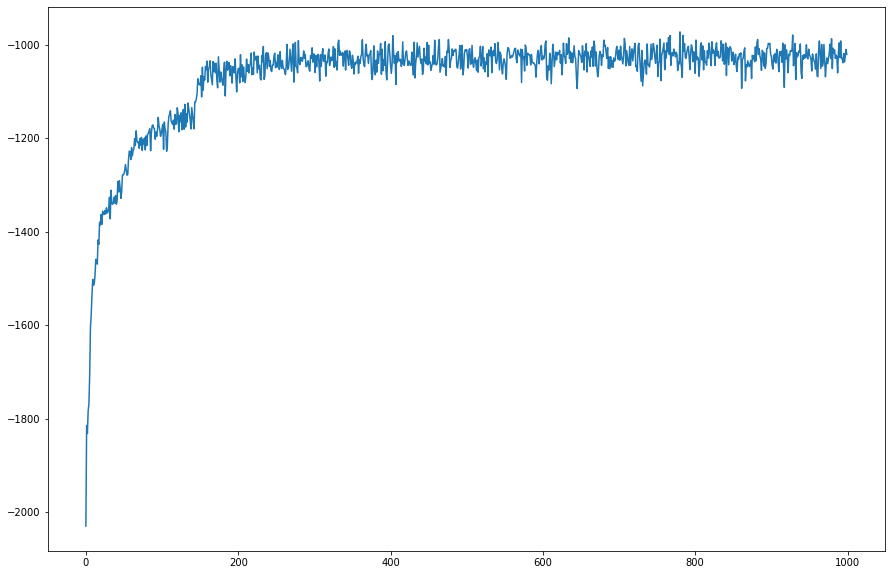

In [281]:
plt.figure(figsize = (15, 10))
plt.plot(scores)
plt.show()